In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import kuaizi as kz
from astropy.table import Table
import astropy.units as u

from kuaizi.display import display_single
from astropy.io import fits

#from tiger_cutout_hsc import cutout_one, prepare_catalog # generate_cutout, get_psf
#import lsst.daf.persistence as dafPersist

In [3]:
kz.utils.set_env(project='HSC', name='LSBG', data_dir='/scratch/gpfs/jiaxuanl/Data/')

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [25]:
# Select 100 galaxies
lsbg_cat = Table.read('./Catalog/lsbg_NSA_z005.fits') # This contains both candy+galaxy and junks

rnd = np.random.randint(0, len(lsbg_cat), 50)

# rnd = np.array([5639, 2575,  782,  865,  636, 1205, 3672, 6502, 2581,  531, 6369,
#        5619, 5341, 1798,  472,  742,  523, 5345, 6639, 5890, 4942, 4686,
#        2807,  161,  565, 5138, 3618,   95, 3581, 4915, 4825, 6124, 4654,
#        3804, 1685,  583, 4148, 3393, 7455, 1085, 4428, 5972, 2193,  150,
#        6056, 1109, 1008, 2546, 6907, 4958])
cat = lsbg_cat[rnd]

### Adaptive cutout size

In [26]:
## Adaptive cutout size??  
# Normal objects, use 1.0 arcmin cutout.
# Radius > 20 arcsec, use 1.5 arcmin cutout.
# Radius > 30 arcsec, use 2.0 arcmin cutout.
size = np.ones(len(cat)) * 1.0 * u.arcmin

size[cat['flux_radius_ave_i'] > 20] = 1.5 * u.arcmin # shoud be larger
size[cat['flux_radius_ave_i'] > 30] = 2 * u.arcmin # should be larger 

cat['cutout_size'] = size.value
cat.write('./Catalog/nsa_test_sample_210927.fits', overwrite=True)

### Generate cutout

Run `'/home/jiaxuanl/Research/Packages/kuaizi/diezi/gen_cutout/nsa_sample/lsbg_cutout_nsa.sh'`

In [23]:
from kuaizi.display import display_single
from astropy.io import fits

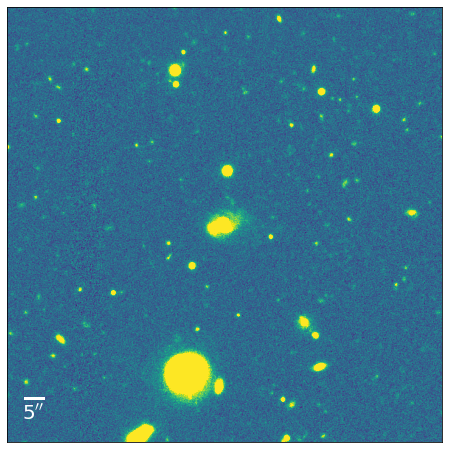

In [24]:
img = fits.open('./Cutout/NSA/nsa_1427_g.fits')[1].data
display_single(img);

In [ ]:
#### Download quick RGB from Johnny's website
import urllib

temp = cat
for k, idx in enumerate(temp['viz-id'].data):
    suffix = ''
    if temp[k]['is_galaxy'] >= 1:
        suffix += '_gal'
    if temp[k]['is_candy'] >= 1:
        suffix += '_cd'
    if temp[k]['bad_votes'] >= 1:
        suffix += '_jk'
        
    url = f'https://hugs-detections.nyc3.digitaloceanspaces.com/hugs-{idx}.png'
    urllib.request.urlretrieve(url, filename=f'{idx}' + suffix + '.png')

### Display cutouts

In [3]:
def _display_cutout_rgb(images, ax=None):
    import scarlet
    from scarlet.display import AsinhMapping

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
        
    # Display
    norm = AsinhMapping(minimum=-0.3, stretch=1, Q=0.5)
    img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
    plt.imshow(img_rgb, origin='lower')
    ax.axis('off')
    
    if ax is None:
        return fig
    return ax

In [4]:
CANDY_DIR = '/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy'

In [83]:
# Display each cutout

for i in range(60, 300):
    images = np.asarray([fits.open(f'{CANDY_DIR}/candy_{i}_{filt}.fits')[1].data for filt in 'grizy'])
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = _display_cutout_rgb(images, ax=ax)
    plt.savefig(f'/tigress/jiaxuanl/Data/HSC/LSBG/Figure/candy_{i}_cutout.png', dpi=50, bbox_inches='tight')
    plt.close()

In [84]:
!mv /tigress/jiaxuanl/Data/HSC/LSBG/Figure/candy_*_cutout.png /tigress/jiaxuanl/public_html/candy/cutout_figure/

### Generate html

In [2]:
import os
import re

In [6]:
# find existing cutout rgb images
figlist = os.listdir('/tigress/jiaxuanl/public_html/candy/cutout_figure/')
figlist = [item for item in figlist if '_cutout.png' in item] # only select png
index_list = [int(re.findall('\d+', item)[0]) for item in figlist]
index_list = np.sort(index_list)

len(index_list)

300

In [7]:
col_num = 7
row_num = 4
page_num = len(index_list) // (col_num * row_num) + 1

In [9]:
for k in range(page_num):
    f = open(f'/tigress/jiaxuanl/public_html/candy/cutout_figure/page{k + 1}.html', 'w')
    f.write('<!DOCTYPE html> \n<html><head> \n<link rel="stylesheet" type="text/css" href="../../mystyle.css">\n')
    f.write('<script src="//code.jquery.com/jquery-1.11.3.min.js"></script>\n')
    f.write('<script type="text/javascript" src="../../myjs.js"></script> \n')
    f.write('<title>Candy Sample Cutout</title> \n')
    f.write('\n\n</head><body> \n\n')
    
    f.write('<div class="header"> \n<h1>Candy Sample Cutout</h1> \n</div> \n\n')
    f.write('<div class="navigator"> \n')
    
    # Write navigator
    if k == 0:
        f.write('   <a href="#" class="previous">&laquo; Previous</a> \n')
    else:
        f.write(f'   <a href="page{k}.html" class="previous">&laquo; Previous</a> \n')
    
    f.write(f'   <a href="#" class="current">Page {k + 1}</a> \n')
    
    if k == page_num - 1:
        f.write('   <a href="#" class="next">Next &raquo;</a> \n')
    else:
        f.write(f'   <a href="page{k + 2}.html" class="next">Next &raquo;</a> \n')
        
    # Write search box
    f.write('<div class="searchbox"> \n<form id="jumper" method="get" onsubmit="return jumptopage_cutout()">\n')
    f.write('   <label class="text_index">Index: </label>\n   <input type="text" id="galind" placeholder="123" name="GalaxyIndex">\n')
    f.write('   <button type="submit" class="buttonjump" value="submit">Jump</button>\n <button type="reset" class="buttonreset">Reset</button>\n ')
    f.write('</form>\n </div>\n')
    
    f.write('</div> \n\n')
    
    for i in range(col_num * row_num):
        if (i) % col_num == 0 or i == 0:
            f.write('<div class="column"> \n')
        ind = col_num * row_num * k + i
        if ind >= len(index_list):
            f.write('</div> \n')
            break
        page = int(np.ceil((ind + 1) / 10))
        f.write(f'      <figure> <img src="candy_{index_list[ind]}_cutout.png" id="candy{index_list[ind]}">')
        f.write(f'<figcaption><a class="clickable" target="_blank" href="../scarlet_zoomin/page{page}.html#candy{index_list[ind]}">Candy {index_list[ind]}</a></figcaption></figure> \n')
        if (i + 1) % 7 == 0:
            f.write('</div> \n\n')
    

    f.write('</body></html> \n')
    f.close()

In [16]:
page_num

11